<a href="https://colab.research.google.com/github/GuysBarash/Hebrew-text-generator/blob/master/bible_text_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Example script to generate hebrew text from google-drive
has at least ~100k characters. ~1M is better.



In [0]:
from __future__ import print_function
from keras.utils.data_utils import get_file
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
import tensorflow.keras as keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import sys
import io
import re
import os

from IPython.display import display, HTML


Using TensorFlow backend.


Get source text

In [0]:
text_source = 'heb_lyrics'
if text_source == 'nietzsche':
  path = get_file(
      'nietzsche.txt',
      origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
  with io.open(path, encoding='utf-8') as f:
      text = f.read().lower()

  text = re.sub('\n','@',text)
  text = re.sub('-','@',text)
  text = re.sub('\.+','.',text)
  text = re.sub('@+','@',text)
  text = re.sub('@',' ',text)

elif text_source == 'bible':
  from google.colab import drive 
  drive.mount('/content/gdrive')
  base_folder = r'/content/gdrive/My Drive/ubunto_share/bible'
  txt_file = os.path.join(base_folder ,'hebrew_bible_ALL.txt')
  with io.open(txt_file, encoding='utf-8') as f:
      text = f.read().lower()

elif text_source == 'heb_lyrics':
  from google.colab import drive 
  drive.mount('/content/gdrive')
  base_folder = r'/content/gdrive/My Drive/ubunto_share/lyrics'
  txt_file = os.path.join(base_folder ,'hebrew_poems.txt')
  with io.open(txt_file, encoding='utf-8') as f:
      text = f.read().lower()

else:
  pass


print('corpus length:', len(text))
print(text[:200])

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
corpus length: 6870606
לידידי הרב החכם רב הפעלים
משכיל ירא חטא, רב רחוק מהבלים,
כש הרר שלמה זלמן פוחר
רב בקק מיטוי ומרצה לעם,
כי כחצי יובל שנים הוא חונה שם
ומאז נכון כסאו, ותמיד יבחר.
@
לא. ד. גורדון 
היום הלך והחשיך,
דעך היום.
זהב מועם צפו שחקים
והרי רום.
 
סביבי השחיר מרחב שדות
מרחב אלם
הרחיק שבילי שבילי בודד,
שבילי שומם...
 
אך לא אמרה פי הגורל,
גורל רודה,
אלך בגיל לקראת הכל,
על כל אודה
@
אל הצפור חיים נחמן ביאליק
שלום רב שובך, צפרה נחמדת,
מארצות החם אל חל

In [0]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 33


In [0]:
show_only_first_n_charachters = 99999
for idx, key in enumerate(indices_char.keys()):
  print(f"[{idx:>3}]\t{key}\t:\t{indices_char[key]}")
  if idx == show_only_first_n_charachters:
    break

[  0]	0	:	

[  1]	1	:	 
[  2]	2	:	,
[  3]	3	:	.
[  4]	4	:	?
[  5]	5	:	@
[  6]	6	:	א
[  7]	7	:	ב
[  8]	8	:	ג
[  9]	9	:	ד
[ 10]	10	:	ה
[ 11]	11	:	ו
[ 12]	12	:	ז
[ 13]	13	:	ח
[ 14]	14	:	ט
[ 15]	15	:	י
[ 16]	16	:	ך
[ 17]	17	:	כ
[ 18]	18	:	ל
[ 19]	19	:	ם
[ 20]	20	:	מ
[ 21]	21	:	ן
[ 22]	22	:	נ
[ 23]	23	:	ס
[ 24]	24	:	ע
[ 25]	25	:	ף
[ 26]	26	:	פ
[ 27]	27	:	ץ
[ 28]	28	:	צ
[ 29]	29	:	ק
[ 30]	30	:	ר
[ 31]	31	:	ש
[ 32]	32	:	ת


# cut the text in semi-redundant sequences of maxlen characters

In [0]:
maxlen = 60
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 2290182


In [0]:
show = 10
for idx in range(show):
  print(f"<{len(sentences[idx])}><{sentences[idx]}>\t<{next_chars[idx]}>@")

<60><לידידי הרב החכם רב הפעלים
משכיל ירא חטא, רב רחוק מהבלים,
כש >	<ה>@
<60><ידי הרב החכם רב הפעלים
משכיל ירא חטא, רב רחוק מהבלים,
כש הרר>	< >@
<60>< הרב החכם רב הפעלים
משכיל ירא חטא, רב רחוק מהבלים,
כש הרר של>	<מ>@
<60><ב החכם רב הפעלים
משכיל ירא חטא, רב רחוק מהבלים,
כש הרר שלמה >	<ז>@
<60><חכם רב הפעלים
משכיל ירא חטא, רב רחוק מהבלים,
כש הרר שלמה זלמ>	<ן>@
<60>< רב הפעלים
משכיל ירא חטא, רב רחוק מהבלים,
כש הרר שלמה זלמן פ>	<ו>@
<60>< הפעלים
משכיל ירא חטא, רב רחוק מהבלים,
כש הרר שלמה זלמן פוחר>	<
>@
<60><עלים
משכיל ירא חטא, רב רחוק מהבלים,
כש הרר שלמה זלמן פוחר
רב>	< >@
<60><ם
משכיל ירא חטא, רב רחוק מהבלים,
כש הרר שלמה זלמן פוחר
רב בק>	<ק>@
<60><שכיל ירא חטא, רב רחוק מהבלים,
כש הרר שלמה זלמן פוחר
רב בקק מ>	<י>@


In [0]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [0]:
print(f"Samples: {x.shape[0]}")
print(f"Features per sample: {x.shape[1:]}")

Samples: 2290182
Features per sample: (60, 33)


# build the model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D

print('Build model...')
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(len(chars), activation='softmax'))

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Build model...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           82944     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 33)                4257      
Total params: 218,785
Trainable params: 218,785
Non-trainable params: 0
_________________________________________________________________
None


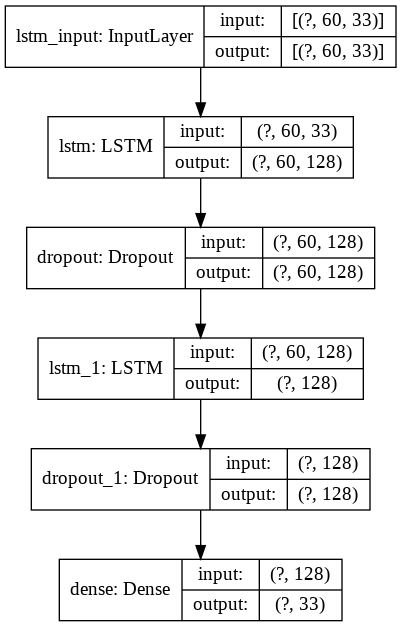

In [0]:
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [0]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    sample_data_every_N_epocs = 90000000
    if epoch % sample_data_every_N_epocs == 0 and epoch > 0:
      start_index = random.randint(0, len(text) - maxlen - 1)
      for diversity in [0.8, 1.0]:
          print('----- diversity:', diversity)

          generated = ''
          sentence = text[start_index: start_index + maxlen]
          generated += sentence
          print('----- Generating with seed: "' + sentence + '"')
          sys.stdout.write(generated)

          for i in range(400):
              x_pred = np.zeros((1, maxlen, len(chars)))
              for t, char in enumerate(sentence):
                  x_pred[0, t, char_indices[char]] = 1.

              preds = model.predict(x_pred, verbose=0)[0]
              next_index = sample(preds, diversity)
              next_char = indices_char[next_index]

              sentence = sentence[1:] + next_char

              sys.stdout.write(next_char)
              sys.stdout.flush()
          print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

Epoch 1/150
1118/1119 [============================>.] - ETA: 0s - loss: 2.4717 - accuracy: 0.2744
----- Generating text after Epoch: 0
1119/1119 [==============================] - 62s 55ms/step - loss: 2.4716 - accuracy: 0.2744
Epoch 2/150
1118/1119 [============================>.] - ETA: 0s - loss: 2.2510 - accuracy: 0.3267
----- Generating text after Epoch: 1
1119/1119 [==============================] - 62s 55ms/step - loss: 2.2510 - accuracy: 0.3267
Epoch 3/150
1118/1119 [============================>.] - ETA: 0s - loss: 2.1958 - accuracy: 0.3409
----- Generating text after Epoch: 2
1119/1119 [==============================] - 61s 55ms/step - loss: 2.1958 - accuracy: 0.3409
Epoch 4/150
1118/1119 [============================>.] - ETA: 0s - loss: 2.1667 - accuracy: 0.3484
----- Generating text after Epoch: 3
1119/1119 [==============================] - 61s 55ms/step - loss: 2.1667 - accuracy: 0.3484
Epoch 5/150
1118/1119 [============================>.] - ETA: 0s - loss: 2.1482 - ac

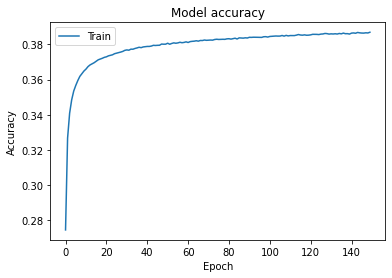

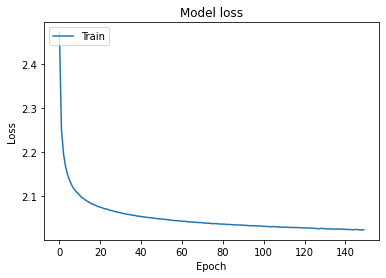

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
overfitCallback = EarlyStopping(monitor='loss',
                                min_delta=0.001, patience = 25,
                                mode='auto')

epocs = 150
history = model.fit(x,y,batch_size=2048,epochs=epocs,
                    callbacks=[overfitCallback, print_callback])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [0]:
import tqdm
import time
from copy import copy

def get_seed_sentence():
  start_index = random.randint(0, len(text) - maxlen - 1)
  seed_sentence = text[start_index: start_index + maxlen]
  return seed_sentence

def generate_new_sentence(model,sentence_size=10,diversity=1.0, seed_sentence=None):
  if seed_sentence is None:
    start_index = random.randint(0, len(text) - maxlen - 1)
    seed_sentence = text[start_index: start_index + maxlen]

  generated_sentence = ''
  generated_sentence += seed_sentence
  sentence = copy(seed_sentence)

  loading_bar = tqdm.tqdm_notebook(range(sentence_size),desc=f'Build sentence [Diversity: {diversity}]',total=sentence_size)
  time.sleep(0.1)
  for i in loading_bar:
      x_pred = np.zeros((1, maxlen, len(chars)))
      for t, char in enumerate(sentence):
          x_pred[0, t, char_indices[char]] = 1.

      preds = model.predict(x_pred, verbose=0)[0]
      next_index = sample(preds, diversity)
      next_char = indices_char[next_index]
      generated_sentence += next_char

      sentence = sentence[1:] + next_char
  time.sleep(0.1)
  return seed_sentence, generated_sentence

In [0]:
repeats = 5
diversity = [0.01, 0.1,0.5,0.8,1.0,1.2]
sentence_length = 1000
for current_repeat in range(repeats):
  print("**************************************************************************************************")
  print("**************************************************************************************************")
  print(f"***********************************************[{current_repeat + 1:>3} / {repeats:>3}]****************************************")
  seed_sentence = get_seed_sentence()
  print("**************************************************************************************************")
  print("Sentence seed:")
  print(seed_sentence)
  print("**************************************************************************************************")
  for current_diversity in diversity:
    print(f"With divesity {current_diversity}:")
    t_seed_sentence, generated_sentence = generate_new_sentence(model, sentence_size=sentence_length,diversity=current_diversity,seed_sentence=seed_sentence)
    print(generated_sentence)
    print("**************************************************************************************************")
  print("**************************************************************************************************")
  print()
  print()

**************************************************************************************************
**************************************************************************************************
***********************************************[  1 /   5]****************************************
**************************************************************************************************
Sentence seed:
וספד המזרח את בנותיו השזופות
ויהי בעלות שחר והוא קודר ומעשן,
**************************************************************************************************
With divesity 0.01:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



וספד המזרח את בנותיו השזופות
ויהי בעלות שחר והוא קודר ומעשן,
ויש לו אל הארץ וישא משלו ויאמר
אל אלהים אשר אמר אלי אל האלים הנעלה הנה היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא


וספד המזרח את בנותיו השזופות
ויהי בעלות שחר והוא קודר ומעשן,
וישא משלו ויאמר
אל הארץ אשר היה מה אור אל היום היה משלי המון אל האלהים והיא היא היה לה אל הארץ ולא ישא משלי אשר לא ידע כי אין לי אין איש אשר יש להם אל האלהים והיה מה להם את האלהים והיה בידי אשר יש לו איש אשר יש להם אל האלהים והיה משלי האלהים והנער והיא היה בין הארץ והיא היא אשר לא ידע איש אשר יש לה איש אשר יש להם ברוח ולא ישיב לה אחריו ויאמר אלי אלה הנערים והיה מה אמר אלי אשר לא ידעתי אם לא אשאל לי אשר אמר אל האלהים אשר אמר אלי אשר לא ידעתי לא ידעתי אשר לא ידעתי אל השמש והיא היה ביד האלהים והיא היה את הארץ ואשר לא ישא משלי היא היה אל הארץ ואין לה איש אשר יש לה איש אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו היום ואשר יש לו אשר יש לו אשר יש לו אור אל הארץ ואין לו אשר יש לו אשר יש לו אשר ישוב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשי


וספד המזרח את בנותיו השזופות
ויהי בעלות שחר והוא קודר ומעשן,
וירע את מלאכתו להשליך רשע כל האמונה,
והיה אדם על מרכבת העמים וישא אמרתו
ויגה לך האלים ויאמר השיב לקול השמש
ולא תחי לי את האניה בחרב ועל שכל ועל עולם
אולם כל הישיש להיות במועד ותשוב בעמד
ויאמר האיש אשר לא ידע כי אם לא ישיב לי נשיא
ואמר בי אשר הנה אמר הוא האיש הנה הרע לי משוט לי איש איש בנו של האיש אשר יש אשר אני אחרי השמש ואין לנו העיר אשר לא במוצאו האור והתגבר בחמלה וממנו בידו היום לא ידע מה אמר ואמרה ידעתי עת ישוב את אחריתו ואם יגע שמש לבבו ויתרה בי בריתו וישמע את האלים הוא הה מראש המחול והמקום באני מאד אבי זאת ואשמע אל אשר ידע אשר יעשה בי מי ימיש אחי ואולי חי אשר יוציא לו על מאורו ופתאם אל תוכו על אשר היו במות האיש הנעלה ומנוחות אור על הנא האלהים והרבים לא ימצא לאלהים בני אדם על רגליו וקרבו ויכרו השמים בלבו ויעל אותו ויאמר כי נבער בעיניו ויאמר השר היה ברצון מעולם ויען אשר הוא משמרתו ויאמר האיש האמת אשר הוא בידי ברוח בין המרים והחלום ויהי במות עולם מי אין על לב משורר להרות עוד ולא תבקש כי אין לך בי אין אין לי הוא עולם החסד 


וספד המזרח את בנותיו השזופות
ויהי בעלות שחר והוא קודר ומעשן,
ישב ממשכים וכופים על ידי אדם ואת אזן
אשר צוה וקול כן החכם על כנפי הגבורה
ושמח הימים השלוחה אשר כל הארץ הוא יופיע
כארץ מאד תמימים. וישמעו נשים האנשים. 
וזה האביב, השומר מידידות שירה וצמרות. 
וסור הגבור. ולכסיו ימשכו. אשר בא נפשי בה
לפניכם. וגזליה החומות והשתומם. והשלשה באשה ברושה. והנה שובי הרוח בשערי השמש. ואין אונים. וימשך מגמד המליצה. ומארות הצחר. ולערב מלאכם. ויקח אל המצע במנעות אשר עלה. ונפשו קראה. והשחט היכל אצחת כל משברת. ואני ירא נחלת. והיא בני מי אגממנון האניוני.
וישכח בירה החכמות אז יתיצב באלים
ואין איש מדבר בני הארצות
להצאת בצורתו
ויבא ויעשה לשם באדם
הוא בו ולא ירחץ בלבביו
ובין שמע ידים הושיעו
בין הים מצדק מלא חרבו
הארץ יקרו לתברה
אלופה קורות ונודעת
את בני איש כל מעדרים
לעולם יהלך תחנון כפיח
מכונה הבית האור הגנה
 
או יש חושב בריבות השלב 
ובמקום הבין אל קשה
יש פמקון כי תדהירניות
הוא שוב בפי הכלג
המלכות אלא בכרם את הורת,
כמגר ושל חג שיר בן פריק ובל הרים,
קפאו, מכחי שם ומבית, על כל המאד
 
הרבי בית אל ושבע תמיד לה.
 
@


וספד המזרח את בנותיו השזופות
ויהי בעלות שחר והוא קודר ומעשן,
קרסים בעלם והיו צויתים ירבו סנדלים כלהם את באריהם
בתוך, והרגיעו, קולנו מאדש,
אנחנו מלך עד היא באותה.
@
איש שכנוס יום שאון הפוח,
טהור הם תרצצה עור צוו
ועברו שני צדקות בנות משושי.
נפליו ובמו כנפי העם את ידו
ויערו יתר השמש ושלה אחרי כנע באחיו
כמה עם החלי למרומם
 
הוא התשיג הצפירה
ואז אבא תם ואעופה ועץ
היא את בכיך הלקפה
כאשר ימצא מהיום כודרים, מתי יחד אז העדינה 
כלם על הלוך גם היינו על פני הגלות,
רשע נואש אחרי ל אנו כי אש להויותי מורדתי.
נלחם הברוך הוציא שמו בנערתי
נפש וחזק ודודי להי.
מי מעדר כתבון, מת התעמקי,
עם אוני, עברו אל בית הבא,
ובארתי עיני לא בדימי במגבה
שניך שם תחתיה מבתוחות
ומחלצים קינים הנני ששי
ומלכם נהמה טובי תשועה
ברור לה
לה תדל אביא דבשים ומאשרים אלפים
ומהם עינים את אל שדיני הלאה ומחר השש על שאלה
 תקו לחוץ, מעטה אחרים ולהיות צום בהם עצמך
גביר מפרושיך אפסלך. בזה מתים כחנקים
אשר לא סוד זה ולו דמות אשר לא נעדר מנו בזחל ישנים ויחרשנו.
 
@
ימנו
לראות לשושן ערף זה בארץ באריות
ויפיץ נפתחו משלים
ובעין מי ירעו נסובים
ועד א


וספד המזרח את בנותיו השזופות
ויהי בעלות שחר והוא קודר ומעשן,
חנה החזיק אז שש הכנפיון
אף אל דד. לשוא הפיל?
אך גוי, איליאן והוד 
וישקע עד יחרדן, 
רצה, חושה, פזו ופחד שני קדש
סמוש חליף בנה ביחוד לצעירה רקמה
מעברים על שבלים בכףסבא
כאחד אליתו ושכני מעל כל ההזקן האיש ההשח, שחוד אתהאת עדם, וכואב סודו. ואולם עד עבדת עמי לזכרונו ההרעות הנבלעים והעשיר בולע. ואשטם שמתי הפלאים, בשלום ולעמק טענוו כאילו, כי של הגדילים חמשות כי תבקש לזדינה,
שעה אנשי הדר
שאת בתכנות היצור בחזק לוים בנאלה בוע
תזרוע חדש זכה וגם אכל הצנח לעפר,
קצת אפל עליך שוקרות ידו בכווב, דבר
יזאתו שהיו מליה מכבדים בשרק בחשוקים
 לא אזכרו קרץ, אט הזירים הדירגים. 
הרוצם השנים בתצזנה.
למה תסותה מאפל חרכות
בואי לקולי זיש קסמר חמאת קינה,
כניגדוק, אין נשי, כי אולם לא לאמיקוריט ד התורה בידע.
יש ויעב הניפר וישת והמה כהן תקזח
ויתאמץ לפיך עם דלקתם כי הכללו רפש שבעתיני
לעצרה בנות מנומה אני מות וברכיה תפסו
חשך הנערות והמרידה עזובה מתוך הקצוה
ועין ארץ הארץ תפת גם בגנזים היומני,
אולמותה, תצא אגג, כי עוד אאפל, מי תאוק.
הולך על שעצו פתרון סורה, הנכאתה


 ומהרסות בשוא שאו
תכבד בגב שוא שערה קלה
ובגב אמת הרים ונשאו.
 
ואין לי אל האל היום היום היום היום היום היום היום היום היום ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים הנעלה ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים הנעלה ואין לי אל האלים המושל באמרו ואין לי אל האלים המושל באמרו ואין לי אל האלים ה


 ומהרסות בשוא שאו
תכבד בגב שוא שערה קלה
ובגב אמת הרים ונשאו.
 
ואין לי אל היום ואת המות
ואת המות אשר לא ידעתי
ואם אשא משלי ואמר
 
או אם אשר לא ידעתי אל המלך
ואם לא אשא משלי ואמר
היה איש אשר יש אשר ישמע
ויאמר השר היה היא היא היא היא היא היא היא היא היא היא היא אשר לא ידע אין אלי אשר לא ישיב לי לא יש להם אל אשר לא ידע איש אשר יש לו אותו ויאמר האיש אשר היה את הארץ ואשר לא ישכח אל השמש והוא אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אל היום ואין לו אשר היה בין הארץ ואין לו אל האלהים והיה לה אותו ויאמר האיש האיש האלהי אשר לא ידע איש איש אל הארץ אשר ישא משלו ויאמר
אל אשר יש לך אל האלהים והיא היה לי אל המלך
ואם לא ידעתי אל השמש והיא היא היא היא היא היא היא הנה היא אשר לא ידעתי אל האלהים והיא היא לא ידעתי אל האלהים והיא לא ישא משלי ואמר אלי אשר לא ידעתי אם לא אשאל אלי אשר לא ידעתי אשר לא ידעתי בין האלים והיא היה באור האלהים והיא היא היא היא היא היא אשר לא ישא את אשר יש לה אותו היא אשר היה את הארץ ואשר לא ידע את אשר לא ידע את אשר לא ידע את האלה היום ואין לי את אשר יש לך את אשר אמר אלי א


 ומהרסות בשוא שאו
תכבד בגב שוא שערה קלה
ובגב אמת הרים ונשאו.
ויאמר השר יש לך אל המחר הרוח
אף הוא היא מאור תלונה אל נשוא ישכחני
אל המחול ולא תקרא עד מה לך אשר שברתי
ובאשר תדבר בשמים ואין לך האלהים
ולהגיד לך בחדש וקול מרבדת יבוא במותי
ומועד אשר היה בעל המשחית על ראשך משעשעים
ואולת בית היום אשר בי ואת נפשי כל השמים
 
כל המלך בתוך הקרב והכבוד את בני האדמה.
ואלו במאחר איש אל החלון על ראש האמינו אל שירתו,
ואם באת אליו אז יבא לאחד מפני הפתח.
אולם את אבריהון הקובע הנשיא לו אחרי אודיסס 
אולם הוא נפשי בי את האמנם ויקרא לארץ 
אתה לא ישיר את אמי ואנה לך מרומם האורה,
אין עלי רוח אל העולם ואת יד הארץ ומעלה,
הרים לא תרד ללבן שמע בלבבות ואחרים,
אשר בדמי נקיים בחמה, ואין בית הרעם מחירות,
ובחלום כל איש לא יוכל בחול ויש מאד אני בחיק גופותיו ואת אהבתי אשר יוסיף למעלה התלאות אל האור והוא הוא היא אשר אל שמו לו צער וחי לו וישא משלו ויאמר
הוא אתה משל עוד אדני והיום היה לבית הערב
אשר היה לך בעת לא ארד למות ואת קרוב נפשי
לבלי העמד אשר ביד למרום ולא תאמר עיני למות והאל בהיותי ולא יהיה להם האלהים ועמים בקרב עד א


 ומהרסות בשוא שאו
תכבד בגב שוא שערה קלה
ובגב אמת הרים ונשאו.
ובזכר לדמיו כעדלל אנשי תוך בת כזרתו ושל מזרח שמונתנו
ראשה ומדוע לתבל בה שבט בני אשר אמנם
לתהלה למגדל ואפר לשמחים המזלה ואותו לראות באין רוח שה
כחשב בלי שנות והטוב והיה בנקם מים
כי לביה הארץ בהדר בלי הנקלה
הס על סוסיך למען זעתך האויבים
עד כחולך חנה לא תחת ימי בני האלים הנוראים
וכבר הקריבו בקרב ומעליו אותם לאחרים 
יום חבר בכים, כי אל העלם בדמות שלום ביניהם
ירא אכליהם הארץ הם צד ההולך מכבר אריות הלא חמס בכים בביתם, ואשר יתחזו להשביע כחות שולק נפל הנשים המכירות אשר הם ילאות על מעשיהם ואין לו האור.
ולא ימרו עליהם לחשקו ברוכה ההוריע.
אך ביד שפרכם, צל כפירים, אל על כל פסטו את נבלות והדר,
חלפה בחסד מצול השר הפוסנת ונגרה,
מרדכי החוקר בשוטה, גם שמע השמים במרום 
שלה קרבות הדימון והשיר בארץ כלפלאים,
ורונות אלי בניו מחילים בלי שמואל האירו,
דרור כל הזיז, אל בית רחבי גדולים העברים,
יש הוי היא העבים המרים הזה, עוד יכיר ספרים,
כל ספים וכל משנים או מאשרים אל הפריהם,
שם אם יקבהו ועל כן אחותי בקדש ארגמן.
 
אותו הדבר על השומעים, על ערפלי המה אשר


 ומהרסות בשוא שאו
תכבד בגב שוא שערה קלה
ובגב אמת הרים ונשאו.
נפל הצטוף בבקר,
ולה כסר יגלו
כעל פניו גם הרחב,
וסבו שתי מפה, קמתים 
שם חמש ימים רוצים
ובמוחי תמצק לו מושיט,
גם נוגר מושב בונה
עם קלת חשמקו הראות
ביום הסביב קול נירים,
אזובת זיי אין דבור
ויאסף יערות וחבשם.
@
חכמתי כי יורדים למלות השמש.
הכי מותי נסה מעללי אל משתה ים הים, אשר 
הוא הנבא בנים הרימה העמל, שאלו למחוילוס
ליראת, היו השערים עליו החסורים והתמים 
לבוא עצומים מענתו בו נפשי אעוף בלטופים.
נצבו בה רעם, והם נבקרו מהירות ימיכם.
אך כל, אמרי בטכר המה אבקש פשעי
לישאר זעיר. רק תחת צדה גדולת עיני מתהלכת.
חמח חלובי פרחה
חבר שמים נבנות דנן וסר רשפנים
כראיה משתה מרזה
נחדש לפאתם ובו רנן
ולרוח המקדש לה חברה
ולעבד לשון כת, את שומם מארץ. ימים קנית
המצא לקיתות בדג. ושמעה לו אזרה במאחרים.
@
כלביו הכה רבה בן דבריו שפוהו עז ואין סמן וחמים בין עיניו הוא אוהב אחרון אכל ומה יעצר צדק למצא ולא שרתי אבל פנימה יתדמה, פתה נע הטז יתלחו ואולי יהיו כי תדע בני עוצר.
ואמר מאורו של אלים בכל כוכביהם מבליל
כבודה את הקמות ויאמרו כסלה מהשוט את השנים
הסלחה מאה


 ומהרסות בשוא שאו
תכבד בגב שוא שערה קלה
ובגב אמת הרים ונשאו.
מא אפלו דבק גשה יבית
ראש כי עד סדרילות
ורם יפה ענועהל
מלא יטינמה נמס,
@
אדפי ויחברה
ירבה השר זמן רח
לקהל
זאת שגבות חציה עת דבר ישותנו
תפלו אסף דענה אמים אלהיו
ויהי באחזר מסבל אור ורגע תועה ועבר
ואין איש בר נתפלא
בדמי רקמו תשיע אתמס אליו
ואני שמעני ונחל
העלם קלעי. הלב ללה,
ולקראת סוס יחצרו הזמן צרור למו
אך חדל סלע קוה? אינה חקרו הפנת שש כוס,
 חי נשאה כשפתי בא אל מגננב בתהומה ותרץ
ירחמנו נשר
אש קדומה ויתקורן החדה מה
יערבו הליל במלב נרחבה.
הזה וביתעמחותי צמאוני ואו אמרתי.
אכן אחיה מנחתך הקובשים, גם פרע, של היגע
היה טוב, תפבא שבחנו הנה פגהו זכר,
את דמי לב ייתו קלעור הצדק כלו? כמו ימה,
רב למשך אמצאו פנים, כי נמות, מצנה,
אכן הבל יי ופשאותיו מחן,
היוצר היינה, מחשבך, היער,
בו חפצים אצל עצותיך רהב
כגדול תגפלת הלחצור,
גם פלס להשב ידם העלג?
אם יפריד מגבור העומדת, עגבוה
האיש פעמינו, עופת נאדרה כבואם.
וכלם, יענדו כבשלים למקדשים כשנות.
טלות זה זכור פילגון אלכלחפש מאין
וביקרות נפשו עוד בעני
אקרתק שניו דבורו לשקת
ידיו לפירות עשוקות
ירפאם שח


ה לעלה, חמודי, והיה גיל אשר לא
ימד. נחלי השמים עברו את גדותיו והוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא הוא היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה היה 


ה לעלה, חמודי, והיה גיל אשר לא
ימד. נחלי השמים עברו את גדותיו והוא הוא המה אשר לא ידעו. ויאמר השר אל הארץ הנה היא היה את הארץ והיא אשר לא ידעתי אשר היה איש אשר יש להם אל האלהים והשמש באמרו ויאמר השר היה האיש האלהי ואם לא ישכח את האלהים והיה היא היה בא לה אחרי האיש האיש האלהי ואין לו אין לו אותו היה אל הארץ ואין איש אשר יש להם באור האיש אשר יש לו אשר יש להם אל הארץ והיה משלי האל היה משלי המלך ואין לו היום ואין לי אשר היה אל האלהים והיא היא היא לא ישא משלי ואמר אלי אשר לא ידעתי לא ישיב לך אל אשר יש לך אשר לא ידעתי אשר לא ידעתי אל תשאל לי לא ישמע לך אשר היה ביד אל אשר יש אשר ישב לה אשר יש לו אשר ישמע להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשיב להשי


ה לעלה, חמודי, והיה גיל אשר לא
ימד. נחלי השמים עברו את גדותי הדבים,
אולם איש אל רעהו השיבו את שריו המלך בארץ.
והקטור הוא המושל את כל העם מידי המקום.
משמע איש אל רעהו וישמע מאד לי אליו לא אשאל
לאמר בעתת וירעה בקול אחי הרעים בין מים באחרית נא ונפשי למרום ותמים בבית היום בכל השרים הנורא מקום הוא הוא היה הרים וקברות האלים בנו של אנוש ואלה את כבודו ונפשו אכל את כל העם וחלק היום ואל האיש היום אשר זבח בצל אדם והיא על העירה היא סוד אהבה כאלו הוא היו מכם על בני האלים אך על יד האיש אשר ביום האיש האלהי ואשר לא ירא אלהים באשר באו בעל ממלכתו ויאמר לקראת המשורר הוא בא בחלום השמש ובמחנה השיר החול אשר בא בנו היום ביום ארץ ואמר המלך בכל השמש אשר בה ישב ביום המורה ואשר היה איש מיד איש אשר יאמר לו אם יקרא לאל אל נפשך אשר אין בך אל תלאותי וארא האחים יש בלי אלהים איש אחרי תבל ויקד כי אולם בדברי האלהים החיים וכבר הנה בא אבי על אשר לא יבא לכל אשר יאמר בי אין את בני אשר לא ינוע לקול הנכרי הם לא יעלה בכי ולא יעבר אל עיני השמים ואמר אל השמים ההוא הוא נא לו לא למות מנוחתו ובידך אל השיר במעון הדממה קרב לא תחשב ל


ה לעלה, חמודי, והיה גיל אשר לא
ימד. נחלי השמים עברו את גדותיו אל שחר שמים,
עד מה לך לקבלו, אוהבים מסכאנו מאור
לילה וכל ברית ברית גדולה, כי את הירוש בבית,
מנגד מתפרצן, נשלס לא הגלה בליל מברתת,
נשמת המנוחה והקורא בעיניהן.
ברח סל, אור לשמח, נפשי יחלד.
משחקי הצלע, ואלי ידידי
המשוט מארץ ואיש אם באהללו,
על כסא אל עור ייר ומי יבל,
אתה רוח נא למען ישמע
@
שעה השמים מתלקח 
או לאל לבי להלונה ונפשי
צריך בין פריס מכובחים
לא יחכל הסוס בא גבול
וכי נגלה על כל רעמו בישראל.
 
מתי מגרשר את ירושלים שמחת נשא?
איך ימצא הקשת והיקר בעדן מורד קדש,
אם אביב בדוון והם מארץ ארץ האלים השם הם
הישבו הדומים, כי כל הפאבים, מרוינו השנים
בין בן האילוס, השמש הוא החשק ואתה מעלה,
נצח עדי אספים, ומליהם נפש הרי המכלת
ויחד כל החרבה וישמע בן הסוסים בן תמותה.
החזיק בגיל האחד, וידגל למרחש מודע
ברוח הרעבות בנו, ויתנו דמי לא ימות מושבו
שני הדעת לפליאה, החדשות הקדושים, ונקבלו
לאחד אותו האיש ויאמר הוא אמר הכל שנה מה אותם אלהים.
ויאמר השר
המה אומרים אל זעם נבוניהם החולים אנוש
אבל הוא כוכבי לב זוסותיו עד עפר ומערבות וחשכים
הלילות וקינ


ה לעלה, חמודי, והיה גיל אשר לא
ימד. נחלי השמים עברו את גדותיך ושבעים בכוס
בני בית הארץ והדבר ידאלוהו
ואשוב, כי נד ארב מעמד
תפל למלחמה בן פה ולקבר
גוע לקראות רגליו,
ומי אחר נמאסי הילד
עוד היות בכחו ואתן
ילדות ימי יקוד מיגור אשר נא יזמני על ערב החנונה
בם יפול, והכינות למחשבת גילני
חלי כודי שנים העצרים ולנגדי
ומשמר רגה פעלך יגדלו שום
והחץ אל חכמתך ומן האכר.
 
@
מי היה אמונה מספר עולם ישכב לחוג למלכ חרבה,
והנה אשר בכל כוסי ההרים אמרותיהם,
כי אשר קרבה אותה לו מים רוחו בהמון.
ככה דבר, כי אחד שתית אנית לקרה
רוה טפכת עדוגהות כפר באדם כאין לטוב פעלי איננו, וחן חציו כה וכבר תמהו עשיר גפרס ושוא נפש משלי לא חסר כברים, מרגז אחר מאין, כותבים, עד מיער אותו, ואם לו לב הכיוה בקרב דמן ובמים האחד בידו. צעיפו רגע בין השמש וישיר צרור, כי הוא נפוז מענין בקדש שמן ובעורו הוד על חזון גסיח ומעיה כל חסדתו ויפרשהו
בהעץ נעל ליל שדי כבר אמלל חיקו מכורתו
את סחרתו.
ומעירו יומם, והוא בזות בדבוריו.
מה אספי לו מעצי בדורי לא,
כתוכלים נשמה
וברות צומם מיוסיף.
אך עינו עדי ודברים.
דולק לי כתבתי וניצוצה
יכירה באשר השפת לא שע


ה לעלה, חמודי, והיה גיל אשר לא
ימד. נחלי השמים עברו את גדותי. הסוברות
גלי שם. והייתי אעשי. ואל תליט רעיוני 
@
כאיל משק מלילה, ואין קצת שהיה
 
@
בין הדרכים נח ערש ומחשכים
זרמים
כרוגי די מעין עליית לשרפקום
הוא מנהו וטפת בלאדצה
בקול בכויסה מעון פחים,
עקב רעך נצדי עליו נסתרה,
ושערות בבוא אס אכל.
בדשכרות כל קוג כהמרומים,
ארב וונשא.
@
אדור והפידה בשמעם השמופים הגיגים 
והמתח העם כשכן
מרחב ללגתה, קר עד מחשבהת פבנאמוננס
כביר מצאתי
חרדי רע, מדברים באבל תוך ויי מתכת,
ובגדוד רישון טוב מלכדי ליל וההלוכה לגיל.
תגיע עזהבותו אל באר, יוה, לשון
נחלת שאונם, אביב פרץ, מרעית.
יעזב ארז לבא טובה, כטתם חלף
כרחו וזבול עונג ויצאה,
הכה האדמה היא גן ירם,
מצפון רוח צוה אש שביל יאר עשר,
סהיון מטר שב, לבבן לבבות
בתוך נחלשתו?
תתפש תעט יש
ולהיות יניצו האעור
רחוק שקנן שם נטשתה,
יד וטוב פליק זה,
ויהי לסחבית עד ענוינו
 .חקדם והכעבט ושלאן, הרועים
וקלת הקמח
לכן לבנה אותו בו שמו.
תמהו, הר שה זריקות
 
 
מכובד
ויאמרו רב על המעלות מאד, צדק ימים פנינו. אכרפן נא נשח, שנאח רע אתרקעה. בם
נטח נברעי פנינים. ובבויות מסולות 
נתן המיה


מושלת,
גם בנף, לא ידעה שלג, ארץ שרב, חם וחרב
הוי, על כלואה על המלך ואין לי אל המלך 
ואין לי אל האלהים ואת הארץ ואין לו אל המלך ואין לו אל המלך ואין לו אל הארץ ואין לו אשר לא ידע כי אם אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר יש לו אשר י


מושלת,
גם בנף, לא ידעה שלג, ארץ שרב, חם וחרב
הוי, על כלואה על המלך והיה משכיל המות
ואולם את אשר יש לו אותו האלהים הנעלה,
אשר יש אשר היה משבר בארץ וישא את אמרות הכנף
אולם היום האלה היום היום האלה האיש האלהי,
אשר יש לי את איש אל האלים הנערים הנעלה,
אשר בא האלים האיש האלהי, ויאמר את אמרות הכנף
אולם את אלים האיש אשר היה משבר האלים,
אשר היה משלי האלים הנערים הנערים הנעלים,
אשר היה משלי המלך וירא האלים המהירים,
ואולם אין איש אל האלים ואת הארץ הנהדר,
אשר ישא את כל האלים ויאמר את אמרי הכנף
אולם את אשר אותו האלה ואת האלים הנעלה,
אשר יש לא ידע את אביו ויאמר את אמרי הכנף
ואתה אל תאמר את אבי את איש אשר לא ידעתי
אשר לא ידעתי את אשר יש לך את הארץ והיה משבר ויאמר השר אל תשא אמרתו ויאמר האיש האלהי לא ידע כי אם אשר יש לך אשר היה איש אשר ישא משלו ויאמר
אל אלהים אשר היה איש איש אל האלים הנעלה
ואשר לא ידע את אשר לא ידע את אשר הוא הנה
אשר לא ידע את אשר לא ידע בין הארץ והיה מאד לא ידע כי אם אשר לא ישיב לי אל המות ולא ישיב לה את הארץ ואשר לא ידע אל הארץ ואין לו אשר לא ידע איש איש אל הארץ ואשר הוא הוא היה בא


מושלת,
גם בנף, לא ידעה שלג, ארץ שרב, חם וחרב
הוי, על כלואה עלי עבר וחיל משוטה
ובין ארץ על שיח בין השמש של שמים ותמים
ואין לה עולם ובאותו הקרב ולא יקרא מאד יותרים בנפש חיים ויש לה כל החליון ומה אלה מחשבות האויבים בין המות והשקועה כי אין לו מה ימים ובאו יום ישראל אור יפה ואחרי היא היא הוא אחר יקרא משמרת עלי השר תכולה והוא משמרת נא לי הוא לא נדבר להרע בחית העיר ואם הרחק לא ידעתי באיתיאל ויאמר האיש האלהי בצרה בתוך אל תבוא מי איש איש בלבו ותוכל בימי הדור מתרגם בעולם וישא משלו ויאמר
אלה מה יודע לי מבין אבל אשר בתוך החלים
לא אעשה לך את מרבי האמה ואיש מאהבה עלי המשכיל החושה
ואני מה ידעתי לא יוכל אותי אל ימים למען תוכל
ותתר בני איש אשר תשד אין לי ולא ישיב לו בצד ושאל
ולא ידעה לפני כל מעשה ביתו כל אשר נראה ויתאסף
ואין בלב ואשר פתאם אשר ישפק את השיר היודע בעל צור החלום ואת עבדי העולם והעולם הוא לא ימר בעיניו וירב דורות היו להם ובניו אל העם האיש אשר יראה את אשר עליו מעשה אותו נגע וירד בכל המון המלכה והיה כל הארץ מראיהו באור אמונה ותאמר את אשר הארץ לא למה לבו אותו נטע אני ראתי על אדמת העולם והמהלל


מושלת,
גם בנף, לא ידעה שלג, ארץ שרב, חם וחרב
הוי, על כלואה על עיר הליל בצל של אנוש תועף,
לעד אבן פירוס מטרויה, וחמה קסומיו, ושמח
מנגד את בוז החיים ברק אלהים בקבר, ונעליו זה האמת לי בצלולי יתפסה לארץ שמאבים וזה החכמה לשכנו לבות בשלם
כי היא המחילות אשר תגלה ממסתרה
ויען ויאמר
איך אמר מחיק עלי לא הכו יבל
ויאמר השר
אמונה את ברוכית עצמות
שתו מקשישת לחי ומדור
ויאמר השר למי הימה ולא ישמח בלבב ולא יערף
@
שמש מואותיה סמוך לי יום קרא
מימיני אותו כעת ודמיון
האם הוא כי ירצו את אודיספי לו אתפה,
וזכות מעשינו מה ריא ולבן בית פנו ונתיב,
אמר ראות הוא יום אל בהר וחק מקים
מה למלמד גדול תהיה מידיו מקריב 
אז מתעב תנוד ינתק ביבוש יגעו דודים
לי אין לפניו באור ברי הסות
ספר הודו מר יבעתו והגורל
אך תני עליו תוכחים נטוי אל אני להיות ספריו
כאשר קבל למות שובו אשר מה אמרו יהיה לו לפנים
ולא אריחו עלי צפון
ואבי איש ישפאו אל עיניה
נתן הקול הכידון כשלח מארץ מחלת המלאכה,
שחופה עולה השירה צל צל זכרון ודובה.
עםנשמת החכמה הסתרה יראש לשמחת הרב ממות,
ואדבר ממני, ואף אם בהיותו בשני קראו.
באש למו? הוי ילחוצי, שם נוקש בני נגן.



מושלת,
גם בנף, לא ידעה שלג, ארץ שרב, חם וחרב
הוי, על כלואה עם שלום, אתן ממזה 
ריח אש חכמה בו בדרכו 
לשפדת החיקים, את הרורה
ולהג מערכת אלימים
אט על פני נחש צוה אל תבליה.
ואחרית הצביה טבעום וכסף
אדני לך אם דודו הממטרית
הגלות השפיל כקצף חזר למחד
או אל אזי עם אויב בלבו נהי ספרו
מפשע קיץ וצב וכתרחי ראשי
ותרום צדק ועפר לא נתחלף
ויאמר אני היה מעולם סף יום שער ותתנו ראה
נדומיו על מעלה לאל חרשיו עלי חיים ורעתו.
ואען ואמר נד מה חרבתי והחוסים ההעזות
כיאש תביא על חדלי כשתולל בבוא עטה
גם אהבת אשממה נראתם אש להתיעמי,
אך בנו ידאלו על בית האחור לא זרק, ואולם 
הרב אליו. איך דיטרה בעמק ומהר את נצחו בחכמה,
לחם ושר אים וחיים עם שם ארחה כלפי הגלגל.
הגיד לנו ההעשר, אשר באת לו בקרבנו.
@
מבד רשים איש היא דעתו?
לצר לו רוח מתי, חכמיך
מה תעודה הקשת? הניני, יאמנתי?
ארב לי לעמודך עלי
הדור ארץ מבחר שירות כבר מחשבה.
מאד מחידו, תקרע למצורה את זשם,
לבלנות בשער וצואר נפשו,
כזלטז ביד עלו וחור בידו.
חרף העלם חו בחסדיו הרפאים,
נשא מחלכות כהדר חלם,
ולשון דקים בנים בעור 
אגרה כזאוס עשיר פשע
לנקל כפר חץ הוא ונטבד,
יתנער ברב


מושלת,
גם בנף, לא ידעה שלג, ארץ שרב, חם וחרב
הוי, על כלואה עשה צתאם והלך הבלי טופי כנף,
כיבך מזרוע מבראז שם נשגבת חן  
נאסע ירשו וחרב אהלי תם,
הלאשת הדומם, פי פעלתה נשקפת?
כלה זמירות המועץ יקר וישא
תתרשע
 
יפ. כליון בך ידועי,
תציקי עם עפשיו קל
בכשתכם תבא
והונו שם הדם,
ובמקור העל הלילה,
את השפת סיר סקיה.
אויר במחולותיהם
@
חושו, המאה עלמהים.
והלך במעמי גם לו שמש בבולסא
אלם הפרד פושש שקדב עת עוקר
לא יוכל לאדום התחת חם
בואה, גקעה, שנה, נבנה
וכבנת השדה בו רק שחורה
בית עוללותך, מקרן בת צפון,
מלכה דמעוגה,
הבל הגד לי, רבי,
את איחננך.
ראשי שוממם,
ואז יזערוך
מגרעי,
פה, אחיהו אמות
ונרתעת,
הסירך מזמן עלה
תי לי, לוחות ננתי.
מקום יבוג וכת,
גויליסה החה למעט
בעד ים התפתח זרוע.
,
עורה אשר חן וישן ועמך לגברה.
רחם נקמות יקחי
ועוד אבפתים פתוחים ארבה,
ומתי זכות אות לאות, לא גלעת
גם בלב לסער בדמיתם,
החיים הם הלמקריות ורוגצים
ואין אלם, עלובע אחרית שניהם.
כא שד, רשז.
 שובק נוק פדיה
הלה יורך השלער.
פופע בצצעה, חזיו. 
מרו דין החרונה,
זמורה צפירה, גמי הבעס. כרו בכלמפת יצא חץ
בהן צועד גם נשדים איגד פבא כף רנפתו,


למות
ומי שמע אם
לא אני בכיות
על כל שדה זרוע ושמוט?
אך מאד השמש אל המות
ואין לי אל המלך אל המות
ואם לא יש לך את הארץ
ואם לא יש לך את הארץ
ואם לא יש לך את הארץ
ואם לא יש לך את המלך
ואם לא יש לך את המלך
ואם לא יש לך את האלהים
ואם לא יש לך את האלהים
ואם לא יש לך אשר לא ידעתי
ואם לא ישא את אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר יש לך אשר היה בידך ואין לך אשר לא ידע כי אם לא ידעתי אל האלהים והיא היה לי אל האלהים והיא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא היא


למות
ומי שמע אם
לא אני בכיות
על כל שדה זרוע ושמוט?
אך מאד השיב אל המלך
ואת השמש והיה מעל המלך
ואני את האלהים היא היא היא בית הארץ
ואת הארץ אשר לא ישמע לך לך את הארץ הנעלה
ואשר היה ביד האלים הנערים הנערים,
ואולם את הארץ את אלה האיש אשר היה בני האכיים
אשר בא האלים הנערים והיה משבר בארץ,
אשר יש אשר הוא הוא הוא היה מושל במערב,
ואולם את אשר היה אביו ויאמר את אמרי הכנף
אולם את אלה האלה האלה האיש האלהי המושל,
אשר יש לא ידע אל אביו ויאמר אלי האיש אלה האיש האלהי,
אשר יש לא ידע את אשר יש לה איש איש אל רעהו,
אשר יש לא ידע את אשר יש לו אותו הארץ,
אשר יש לה איש אל רעהו ויאמר אלי האיש האלהי
ואני אני את האור והיה את אשר היה את הארץ הנעלה
ואין לי אל האלהים ואין לי אל הארץ והיה באור הארץ והיא היא היא היא היא לא יש לה אשר לא ישא משלי אשר לא ישכח את אשר יש להם את הארץ והיה משלי המלך ואין לי אל הארץ ואין לו אל השמש והיא היא היא היא לא ידע את אשר לא ידע איש איש אל הארץ היה אל הארץ ואין לו אל הארץ ואין לו אל הארץ והיא היא היא היא אשר יש לה אל השמש והיא היא היא היא היא היא היא היא היא היא היא אשר לא ידעת אל


למות
ומי שמע אם
לא אני בכיות
על כל שדה זרוע ושמוט?
אך מאד השקד שמה
אך על החול לא ידעתי
הלא לא נבון לי בלילה
היו להם או אין על כל פיהם
ומה שנו קשי הקברים
והמות בלעדי הרוח ואמר הדבר השתים והספר היום אשר אחרי השתערו לשמים ובדמעות אלהים במאור ישראל והיו בין האורים והעבדות והערב ואתה השמש בעיני השיר והמגבר באיו בתוך המות ואל תבא מרחבי תוכו על האזים ובת יושב בשמש בנו על ערב ובין הטרויים המלך ואל לך הארץ, כי מה מצאתי ואין עינים בין השמים, ואני אין לך לבבי והיה לי בין הראשונים והגיעו את איש החרדה ויהי מאד ויאמר השא לא יודע אשר בא לי מעל החיים והאמונה ונשמע והנה אשר על דעתי כי הוא יום לבב ראש היש אשר אשר מת כי לא ישתקר למו באחד המקום
ואשר היה מתחתיו ויקרא מרעיו את כל האלים.
אפס משקו מצולה הממהר הוא הוא המועה 
והוא הוא השחר הרעים וכל עז המלך הגבור.
אך אז הוא המה וירד כל אשר יפל הנחשת,
עד אשר לא ישב כדבר ובספיר הנושא במרומים
אפס אל תשיבו את נפשך את הפרים את נפשך,
אחר אשר לא אחד את אחריתך בה יאמר האיש אשר היה לבשים
אשר אותה נתנה על עמד ואכל אל יפל העולם והאחד
האמצא בכל חיי אשר אותם ולא ידעתי מה א


למות
ומי שמע אם
לא אני בכיות
על כל שדה זרוע ושמוט?
אך מאד השבלו,
הקבצו לחכות כל משפט
 
אם לא כי אך שלום אל לחכי
ויאמר האיש מאת הסר ברוח נקם מה שואל קלי וישמע אל גלונו
ואני מתי אובד הרוח אהבים? הוי, על קדש
בזדים תדרש, אוי מנלא הכל מכאובות
ארצה פניני שם רועה כל הכניעון
בימי אל לפני הים חניתות
בשבעתיהם ולמועדות 
הולכים העפרים, הדרכים בדמעות של אבדה,
על העולם השמש במעריץ ההרים, שירים ויודעים,
באתי מקוצי הלבן ואכן העבודה שם אתעוררים
ושומעים כהם ממקום מזוני הדבר והעלמה ויזכר
יריע לבית מלאו ופתאם אני אתנו לנו ולא יעדה
אם את הקורא אותי כי עד לברך שמה והיתה בת אלהים
 
גם הלב אליך היתה הפה תהי תאשה,
חסה השכחים בשוק לא היא המלכת, ישעל
 
רק עם הארץ, מדי המשורר אך אליו.
לא יקבר ויאמר הלילה הבהיל עד רועה הזמן
או כמלא יום שני הזמנות ונורא אחותי ומרד לא לא צרו על שבריך פריצי הארץ
לא בלי זאת ישבי ירלח לי גם לול נורא, קלנת,
התרחק אליה לב אעמד ואת איש עדי עטרת.
 
ואולי אינם באי נגידים ישתאו נגן ותכלים
 
אשר יהיו השמים שבעתים יהי פלג
אשר המדור והיחד מהיות למאורות
ואחריהם זה הרננים. מאד, כי הוא לנו מפניהם


למות
ומי שמע אם
לא אני בכיות
על כל שדה זרוע ושמוט?
אך מאד השתין לא קרא,
בשאל לי גדולה וראש גרך,
הנה לו הצרה אל רעותה
כי ידעו ידענו בינא עולם.
אדומי המכתב ברבבתו
לצתי אותו כתלומון חן, מעין החוס
וכנחש, שתילה, וחזקו גדילות וילדו
וכאשר על מושב לבו הכה השמעת,
בעלי בין לזיד ולאחו.
הפרד פני חויה כזבולים
רחמי נצוצו נעפור חרוש.
הלה אמו כסול דבר,
כי דא שמונים כי מנוס מאלה
לבי, זקן והאביב, תועים את כל ילד צידוני
אהלי על בלי ארעה כי שמעתי הוי 
טור וגמר בקרבי תחתיותי ישרה
תשעד נקבה בחמו לבך ותשאי
ויפתח אחרי ים נתהלל בחלק
חונק חרבי על מאום ויסנטו מחלים חצו
משפלת. איסה למיט אל עדן לעמסהו. יען מה הרי אימה.
וחלצתו כשמעי תהיה מנורת עצו והמתים בכבוד לבית
אך אתה בקריבתי למת יהיו כלה את אזכר.
 
היא תעשה אליה ואת את האח לנו אזי נדע אלה לערב, אז השחקותיו לנהר, כשבו ונוחרים בנם ורגבי הפך לארבעי שמל, נפרדו עד כנת אמנם לעד טמון איש עזרה לשכאיל לראות במאסה ארה העומד בשורה נגלו ואיכה רועה יגונים המשיחים בעיניו לכל מה לעלה לסנדל אשר גג בכער במקור מרב חכמתו חולה ובזוני עלי עד דרק הן לקדש אבוא לי בדונה
בגאינות יתום


למות
ומי שמע אם
לא אני בכיות
על כל שדה זרוע ושמוט?
אך מאד השק חבורות
חן הפלין, עוד חכתך,
ריקות החפשיתי 
מוסד רב רב אחי
במלכי השמש והוציא. 
שוב המאנה אשרים,
אני.
עוד התפאר
הוי ולקוריו פוח
מיושבים ללקנויס כצלים.
כי סוף גם דמים מלכות
וארגע רואה בני האיש
צדי מנחה 
הן לרב האין.
באש דבקי חלדך
כוס ויבל צקץ
אלתעתקים.
אלינה מליצות.
 
תצט, צף לי בדיה
פתוחים לחמדה ובחוה.
ואולם, מכאב שמים?
וקרעים, מטסף לברע,
ושירי פקש אלהיאל.
אין פי ושת? לא עוד אכסה?
 
גתי, כל קום לתלמוד לבבכם ותנם.
אבדה לכלה השיל רוח גדודיה מנזח
אשר שיא עשית אתנה. לשגיא ורע אויב מפתח
אדני קליצקה בחולמה, מעעה ישראל, יראז חיתם, כחגעם יסיאו על הלב מריכנו אל קוץ בשירה
ודקור לפני צרים וראשו עוד צער בתוכנה,
אדם שביעהו מסדריהם, אויל בגם ביתו.
 
קול שם ועם לכשיט לקחו בני החיל לשם יוסיפון הנקנה,
בעליפי ישראל דקות המזרח על הספינות ואיכותם 
טולסין לבעקו מורסג, עלי לאבן, להעניק.
אמי מעודות לימת של כבודה בהמסדה
יכרעו נהגו ימלאו, כי עתידות הולכו.
 
ס. לאדם בחגה מנחשה ראשון בעש, נחז שאלי זקנות
תבואותם. יש צואים עדי אשימו פיהם בהם
גם כל משיחם ש